This Jupyter Notebook demonstrates how to enable the GridBallast controller for a load (a water heater or a zip load) in GridLAB-D by feeding the simulator a stored grid frequency time series contained in an external file. 

To run this notebook, please make sure you are in a UNIX based environment and have all the necessary python packages installed (plotly, matplotlib, numpy, pandas).

In [1]:
!ls

controller_usage_demonstration.ipynb smSingle.glm
controller_usage_demonstration.pdf   smSingle_base.glm
correct_path.sh                      smSingle_lenient_freq.glm
fan1.csv                             smSingle_strict_freq.glm
fan2_base.csv                        smSingle_strict_freq_jitter300.glm
fan2_lenient_freq.csv                smSingle_strict_freq_jitter60.glm
fan2_strict_freq.csv                 smSingle_strict_freq_jitter600.glm
fan2_strict_freq_jitter300.csv       wh1_base.csv
fan2_strict_freq_jitter60.csv        wh1_lenient_freq.csv
fan2_strict_freq_jitter600.csv       wh1_strict_freq.csv
frequency.PLAYER                     wh1_strict_freq_jitter300.csv
hot_water_demand.glm                 wh1_strict_freq_jitter60.csv
local_gd                             wh1_strict_freq_jitter600.csv


The gridlab-d binary file is stored within **local_gd** directory along with libraries. We need to re-configure the path for GridLAB-D such that the binary can locate the path of the library. If you are using macOS, please make sure you have installed the GNU version of sed, e.g.,

``` brew install gnu-sed ```


In [2]:
%%bash
oldpath='/tmp/temp'
newpath=`pwd`'/local_gd' 
gsed -i "s#$oldpath#$newpath#" local_gd/bin/gridlabd
gsed -i "s#$oldpath#$newpath#" local_gd/lib/gridlabd/glxengine.la

Or you can run **./correct_path.sh** script to correct the path.

In [3]:
!local_gd/bin/gridlabd --version

GridLAB-D 4.0.0-17299 (feature/730:17299) 64-bit MACOSX RELEASE


The above listed **local_gd/bin/gridlabd** is the binary version of the gridlab-d software with controlling functionality. In addition to that, we have **.glm** files and generated **.csv** files. We also have a **frequency.PLAYER** containing the 1-second resolution frequency information.

The version of the gridlab-d binary file and the content of the frequency.PLAYER can be seen below.

If the version of the gridlab-d does not work, we can disable the comments below and run the command to compile the source and install the gridlab-d to the machine.

In [4]:
# %%bash
# cd ~
# git clone -b feature/730 https://github.com/jingkungao/gridlab-d.git 
# cd gridlab-d 
# cd third_party 
# chmod +x install_xercesc 
# . install_xercesc 
# tar -xvf cppunit-1.12.0.tar.gz
# cd cppunit-1.12.0
# ./configure LDFLAGS="-ldl"
# make 
# sudo make install
# cd ../..
# autoreconf -isf 
# ./configure 
# make 
# sudo make install

In [5]:
!head -5 frequency.PLAYER

2012-01-01 00:00:00 EST,59.9769
2012-01-01 00:00:01 EST,59.9763
2012-01-01 00:00:02 EST,59.9715
2012-01-01 00:00:03 EST,59.9714
2012-01-01 00:00:04 EST,59.972


We can further plot the frequency data to get a better sense of it.

In [6]:
# install necessary packages 
# uncomment the lines below if the system does not have them
# !pip3 install numpy
# !pip3 install pandas
# !pip3 install plotly

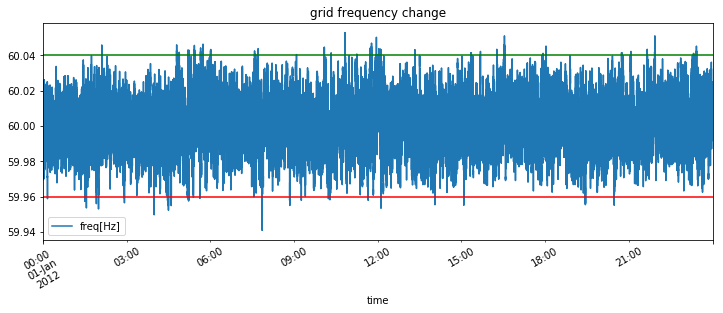

In [7]:
%matplotlib inline

import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode,\
                            plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

raw_freq = pd.read_csv('frequency.PLAYER',index_col=0,\
                       names=['time','freq[Hz]'],
                       parse_dates=True,\
                       infer_datetime_format=True)

freq_low = 59.96
freq_high = 60.04

ax = raw_freq.plot(figsize=(12,4),rot=30,
                  title='grid frequency change')
ax.axhline(y=freq_low, c='red')
ax.axhline(y=freq_high, c='green')

Next, we will run **local_gd/bin/gridlabd** on different **.glm** files and plot the outputs showing the difference with and without controllers.

We start with running **smSingle_base.glm**, which is almost same as the original **smSingle.glm** provided by NRECA to us with the main difference being that we changed the simulation clock and added a recoreder for waterheater1 at the end.

# Base case
We begin with the same circuit provided by NRECA (smSingle.glm), and modify it slightly as follows:

* We change the simulation time to match the time of **frequency.PLAYER** and add a recorder to record the waterheater measurements and the ZIP load measurements (in this case, a fan). Note that we record data for waterheater1 as an example but it could be used for any waterheater. 
* We also set the timestep to 1 second instead of 60 seconds. 
* For a more realistic water draw schedule, we include a **hot_water_demand.glm** which exhibits typical the weekday and weekend water demand usage patterns.

Below we illustrate some of those changes made to the glm file:

In [8]:
# from 2012-01-01 to 2012-01-02
!head -9 smSingle_base.glm

clock {
	timezone PST+8PDT;
	starttime '2012-01-01 00:00:00';
	stoptime '2012-01-02 00:00:00';
};

#include "hot_water_demand.glm";

#set minimum_timestep=1;


In [9]:
# record data for waterheater1 and fan2(zipload) at 1s resolution
!tail -14 smSingle_base.glm

object recorder {
	interval 1;
	property base_power;
	file fan2_base.csv;
	parent fan2;
};

object recorder {
	interval 1;
	property measured_frequency,temperature,actual_load,is_waterheater_on,water_demand;
		// current_tank_status,waterheater_model,heatgain,power_state;
	file wh1_base.csv;
	parent waterheater1;
};

We are now ready to run a simulation with the base case (no control).

In [10]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_base.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 35 objects
Parallelism                    1 thread
Total time                  26.0 seconds
  Core time                  3.4 seconds (13.2%)
    Compiler                 1.3 seconds (5.1%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.1 seconds (0.2%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.3 seconds (1.0%)
  Model time                22.6 seconds/thread (86.8%)
Simulation time                1 days
Simulation speed              32 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock conten

Now, we plot the generated waterheater data stored in **wh1_base.csv** and **fan2_base.csv** from the simulation.

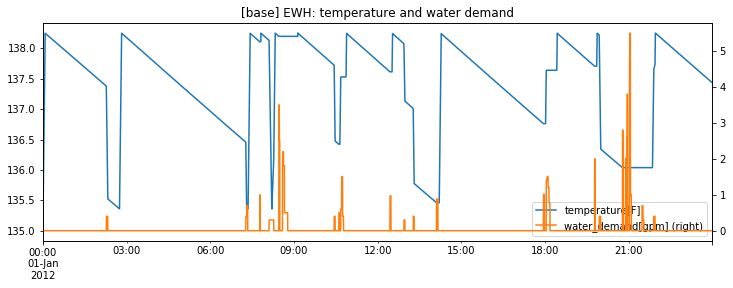

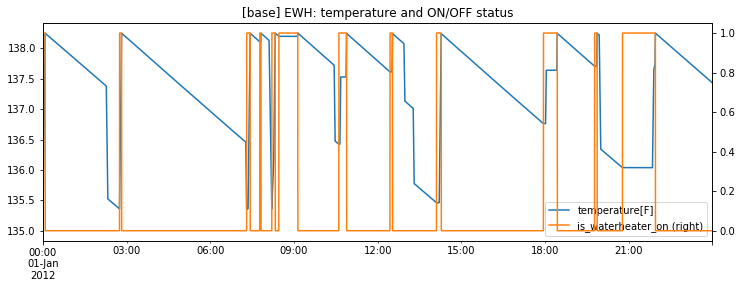

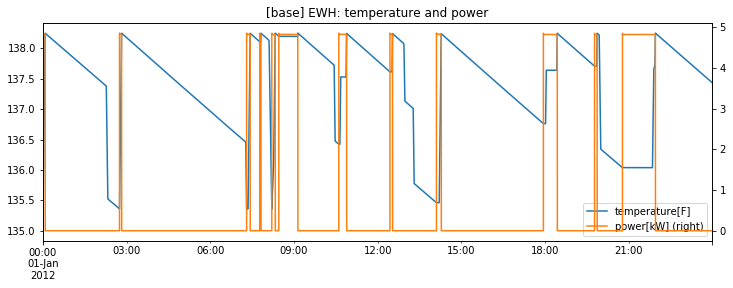

In [11]:
df_base = pd.read_csv('wh1_base.csv',sep=',',header=8,
            index_col=0,parse_dates=True,infer_datetime_format=True,
            names=['freq[Hz]','temperature[F]','power[kW]',\
                'is_waterheater_on','water_demand[gpm]'])

df_base[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[base] EWH: temperature and water demand')

df_base[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[base] EWH: temperature and ON/OFF status')

df_base[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[base] EWH: temperature and power')

In [12]:
# We can also plot the interactive version of the plot 
# during certain period
def plotly_plotdf(df,title='Interactive plot of column variables'):
    if len(df)>20000:
        print('Too many points, please reduce number of points!')
        return
    data = []
    for i in df.columns:
        trace = go.Scatter(
            name = i,
            x = df.index,
            y = df[i]
        )
        data.append(trace)
    fig = go.Figure(
        data = data,
        layout = go.Layout(showlegend=True,
                          title=title)
    )
    iplot(fig)

In [13]:
# we can toggle the varialbe to visualize each of them
# uncomment when you are running IPython notebook
# plotly_plotdf(df_base.resample('1min').mean())

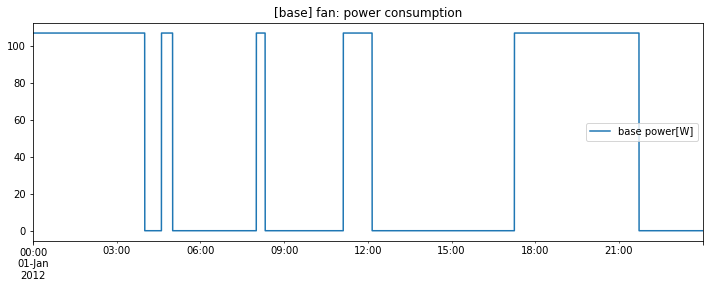

In [14]:
df_base_fan = pd.read_csv('fan2_base.csv',sep=',',header=8,
                 index_col=0,parse_dates=True,
                 infer_datetime_format=True,
                 names=['base power[W]'])
df_base_fan = df_base_fan*1000
df_base_fan.plot(figsize=(12,4),
                title='[base] fan: power consumption')

# Lenient Frequency Control 
To configure the GridBallast controller, we set specific properties of the waterheater object in the glm file. The properties corresponding to the controller include:

*	enable_freq_control       [boolean]
*	freq_lowlimit             [float]
*	freq_uplimit              [float]
*	enable_jitter             [boolean]
*   average_delay_time        [integer]

For this test we modify waterheater 1 and fan 2 to enable the frequency control and set a wide frequency dead-band (59.9Hz - 60.1Hz). We expect the GridBallast controller to be rarely triggered. 


In [15]:
!head -611 smSingle_lenient_freq.glm|tail -21

object waterheater {
	schedule_skew -810;
	water_demand weekday_hotwater*1;
	name waterheater1;
	parent house1;
	heating_element_capacity 4.8 kW;
	thermostat_deadband 2.9;
	location INSIDE;
	tank_volume 50;
	tank_setpoint 136.8;
	tank_UA 2.4;
	temperature 135;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
    };
	enable_freq_control true;
	freq_lowlimit 59.9;
	freq_uplimit 60.1;
	heat_mode ELECTRIC;
};


In [16]:
!head -756 smSingle_lenient_freq.glm|tail -19

object ZIPload {
	name fan2;
	parent house2;
	power_fraction 0.013500;
	current_fraction 0.253400;
	base_power fan1*0.106899;
	impedance_pf 0.970000;
	current_pf 0.950000;
	power_pf -1.000000;
	impedance_fraction 0.733200;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.9;
	freq_uplimit 60.1;
	groupid fan;
};


In [17]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_lenient_freq.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 37 objects
Parallelism                    1 thread
Total time                  30.0 seconds
  Core time                  3.4 seconds (11.3%)
    Compiler                 1.3 seconds (4.5%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.1 seconds (0.2%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.3 seconds (1.0%)
  Model time                26.6 seconds/thread (88.7%)
Simulation time                1 days
Simulation speed              30 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock conten

Now, we plot the generated waterheater data stored in **wh1_lenient_freq.csv** and **fan2_lenient_freq.csv** from the simulation.

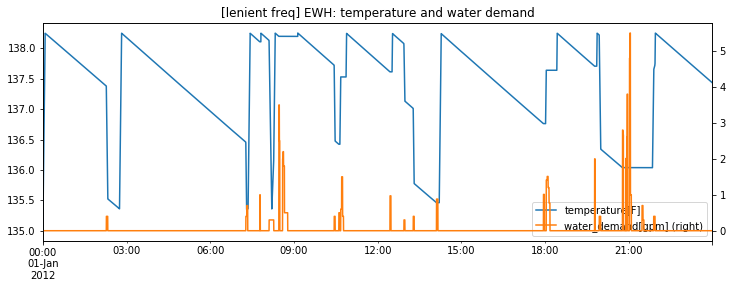

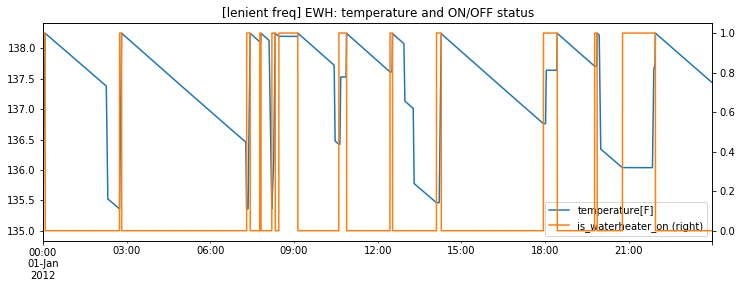

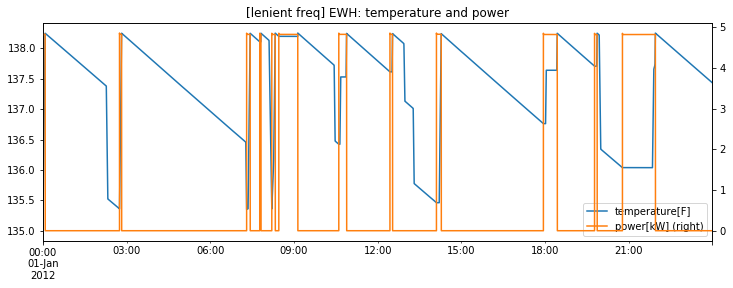

In [18]:
# We save data to wh1_lenient_freq.csv and plot the results
df_lenient_freq = pd.read_csv('wh1_lenient_freq.csv',sep=',',
                  header=8,index_col=0,parse_dates=True,
                  infer_datetime_format=True,
                  names=['freq[Hz]','temperature[F]','power[kW]',
                        'is_waterheater_on','water_demand[gpm]'])

df_lenient_freq[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[lenient freq] EWH: temperature and water demand')

df_lenient_freq[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[lenient freq] EWH: temperature and ON/OFF status')

df_lenient_freq[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[lenient freq] EWH: temperature and power')    

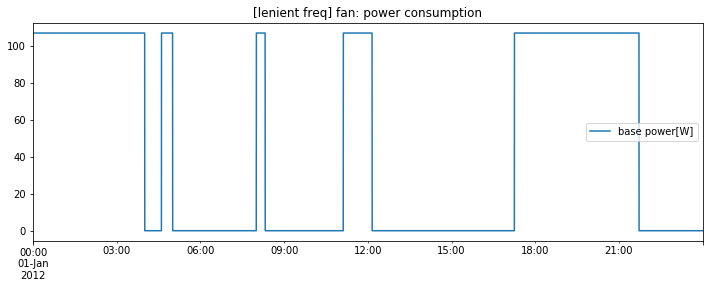

In [19]:
df_lenient_fan = pd.read_csv('fan2_lenient_freq.csv',
                    sep=',',header=8,
                    index_col=0,parse_dates=True,
                    infer_datetime_format=True,
                    names=['base power[W]'])
df_lenient_fan = df_lenient_fan*1000
df_lenient_fan.plot(figsize=(12,4),
        title='[lenient freq] fan: power consumption')

# Strict Frequency Control 
We modify waterheater 1 and fan 2 to enable the frequency control, but we impose a tighter frequency deadband (59.97Hz - 60.03Hz). In other words, the gridballast controller should be triggered very often. 

In [20]:
!head -611 smSingle_strict_freq.glm|tail -21

object waterheater {
	schedule_skew -810;
	water_demand weekday_hotwater*1;
	name waterheater1;
	parent house1;
	heating_element_capacity 4.8 kW;
	thermostat_deadband 2.9;
	location INSIDE;
	tank_volume 50;
	tank_setpoint 136.8;
	tank_UA 2.4;
	temperature 135;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.97;
	freq_uplimit 60.03;
	heat_mode ELECTRIC;
};


In [21]:
!head -756 smSingle_strict_freq.glm|tail -19

object ZIPload {
	name fan2;
	parent house2;
	power_fraction 0.013500;
	current_fraction 0.253400;
	base_power fan1*0.106899;
	impedance_pf 0.970000;
	current_pf 0.950000;
	power_pf -1.000000;
	impedance_fraction 0.733200;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.97;
	freq_uplimit 60.03;
	groupid fan;
};


In [22]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_strict_freq.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 37 objects
Parallelism                    1 thread
Total time                  25.0 seconds
  Core time                  2.9 seconds (11.8%)
    Compiler                 1.3 seconds (5.3%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.0 seconds (0.2%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.2 seconds (0.9%)
  Model time                22.1 seconds/thread (88.2%)
Simulation time                1 days
Simulation speed              36 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock conten

Now, we plot the generated waterheater data stored in **wh1_strict_freq.csv** and **fan2_strict_freq.csv** from the simulation.

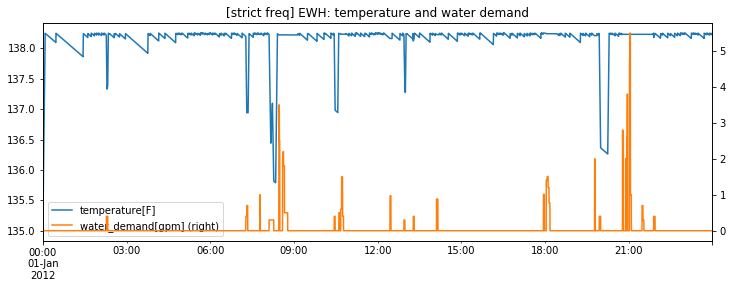

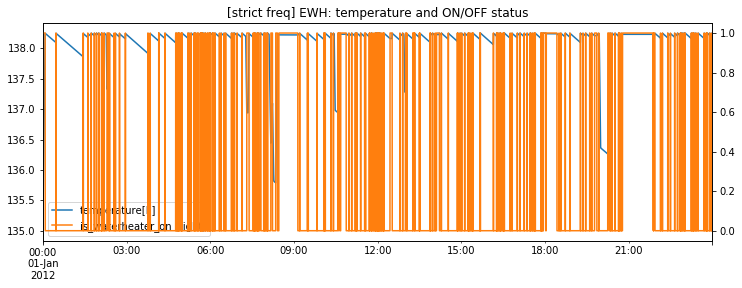

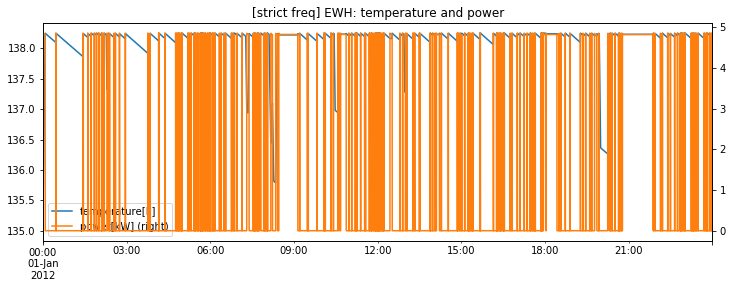

In [23]:
# We save data to wh1_strict_freq.csv and plot the results
df_strict_freq = pd.read_csv('wh1_strict_freq.csv',sep=',',
                  header=8,index_col=0,parse_dates=True,
                  infer_datetime_format=True,
                  names=['freq[Hz]','temperature[F]','power[kW]',
                        'is_waterheater_on','water_demand[gpm]'])

df_strict_freq[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[strict freq] EWH: temperature and water demand')

df_strict_freq[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[strict freq] EWH: temperature and ON/OFF status')

df_strict_freq[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[strict freq] EWH: temperature and power') 

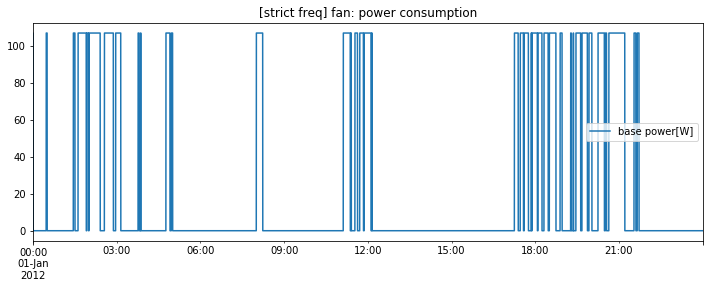

In [24]:
df_strict_fan = pd.read_csv('fan2_strict_freq.csv',
                 sep=',',header=8,
                 index_col=0,parse_dates=True,
                 infer_datetime_format=True,
                 names=['base power[W]'])
df_strict_fan = df_strict_fan*1000
df_strict_fan.plot(figsize=(12,4),
        title='[strict freq] fan: power consumption')

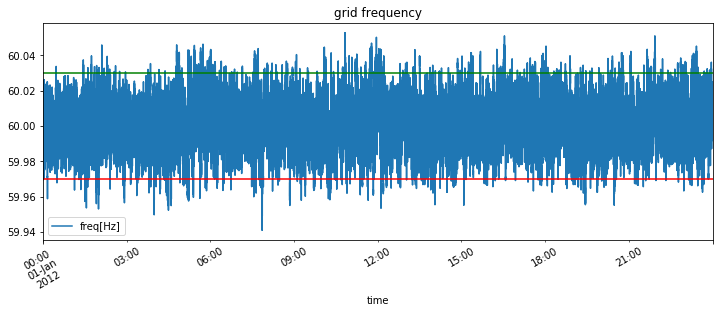

In [25]:
# we can plot the frequency and the lower/upper limit again
freq_low = 59.97
freq_high = 60.03

ax = raw_freq.plot(figsize=(12,4),rot=30,
                  title='grid frequency')
ax.axhline(y=freq_low, c='red')
ax.axhline(y=freq_high, c='green')

# Strict Frequency Control with Jitter (1 min)
We now modify the previous case (with a tight frequency deadband) and add a jitter to the response of the waterheater and fan, such that the start of GridBallast event will delay randomly with an expected value of 60 seconds (1 min). Internally, the controller delay follows a uniform distribution over the interval [1,2*average_delay_time]. 

We use 60 seconds to clearly illustrate the difference in the power consumption patterns of the water heater previously illustrated and this one with jitter control enabled. Needless to say, users can set these values differently depending on how many water heaters are connected to the network or other considerations.

In [26]:
!head -613 smSingle_strict_freq_jitter60.glm|tail -23

object waterheater {
	schedule_skew -810;
	water_demand weekday_hotwater*1;
	name waterheater1;
	parent house1;
	heating_element_capacity 4.8 kW;
	thermostat_deadband 2.9;
	location INSIDE;
	tank_volume 50;
	tank_setpoint 136.8;
	tank_UA 2.4;
	temperature 135;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.97;
	freq_uplimit 60.03;
	heat_mode ELECTRIC;
	enable_jitter true;
	average_delay_time 60;
};


In [27]:
!head -760 smSingle_strict_freq_jitter60.glm|tail -21

object ZIPload {
	name fan2;
	parent house2;
	power_fraction 0.013500;
	current_fraction 0.253400;
	base_power fan1*0.106899;
	impedance_pf 0.970000;
	current_pf 0.950000;
	power_pf -1.000000;
	impedance_fraction 0.733200;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.97;
	freq_uplimit 60.03;
	enable_jitter true;
	average_delay_time 60;
	groupid fan;
};


In [28]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_strict_freq_jitter60.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 37 objects
Parallelism                    1 thread
Total time                  28.0 seconds
  Core time                  2.7 seconds (9.7%)
    Compiler                 1.4 seconds (5.0%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.0 seconds (0.1%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.2 seconds (0.9%)
  Model time                25.3 seconds/thread (90.3%)
Simulation time                1 days
Simulation speed              32 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock content

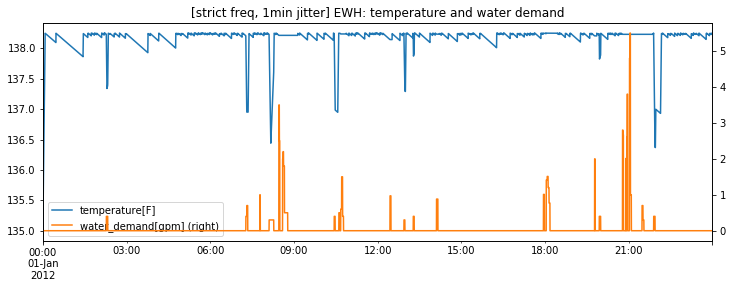

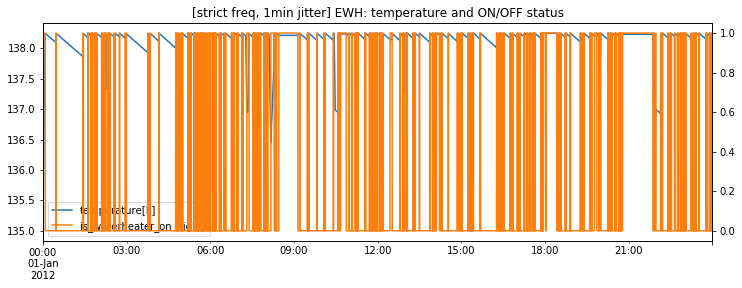

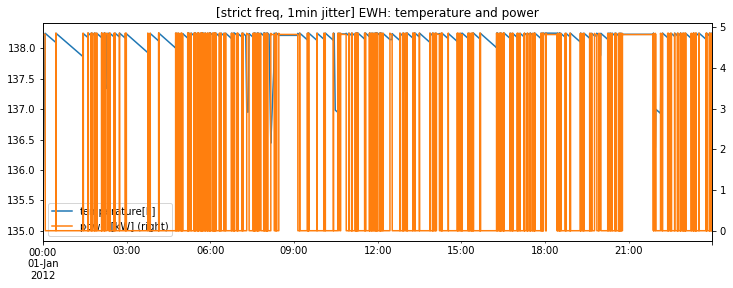

In [29]:
# We save data to wh1_strict_freq_jitter60.csv and plot the results
df_wh_jitter60 = pd.read_csv('wh1_strict_freq_jitter60.csv',sep=',',
                  header=8,index_col=0,parse_dates=True,
                  infer_datetime_format=True,
                  names=['freq[Hz]','temperature[F]','power[kW]',
                        'is_waterheater_on','water_demand[gpm]'])

df_wh_jitter60[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[strict freq, 1min jitter] EWH: temperature and water demand')

df_wh_jitter60[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[strict freq, 1min jitter] EWH: temperature and ON/OFF status')

df_wh_jitter60[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[strict freq, 1min jitter] EWH: temperature and power') 

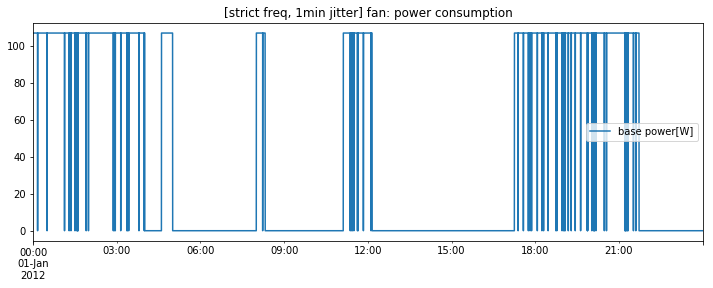

In [30]:
df_fan_jitter60 = pd.read_csv('fan2_strict_freq_jitter60.csv',
                        sep=',',
                        header=8,index_col=0,parse_dates=True,
                        infer_datetime_format=True,
                        names=['base power[W]'])
df_fan_jitter60 = df_fan_jitter60*1000
df_fan_jitter60.plot(figsize=(12,4),
        title='[strict freq, 1min jitter] fan: power consumption')

As we can see, after applying the jitter, the water heater should be engaged less often. However, since the jitter time is too short, we can barely see the difference unless we zoom in.

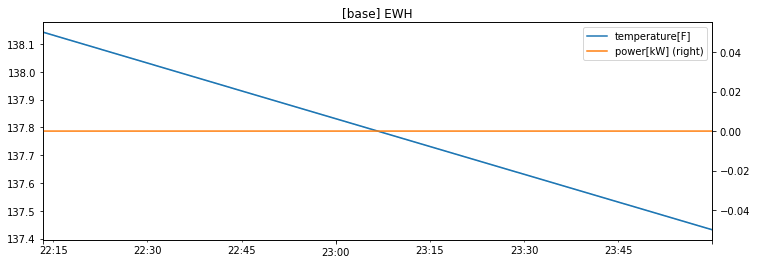

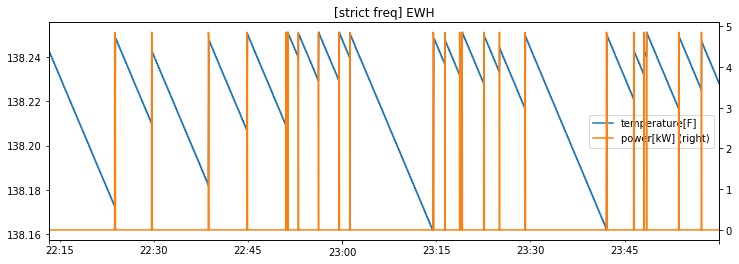

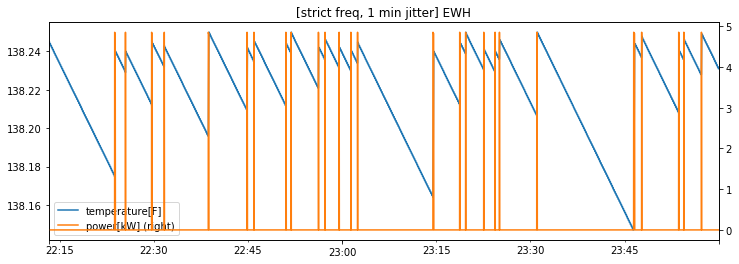

In [31]:
# we look at jitter for water heater in shorter duration
# As we can see, they behave slightly different
df_base.iloc[80000:100000][['temperature[F]',
        'power[kW]']].plot(figsize=(12,4),
                           secondary_y='power[kW]',
                          title='[base] EWH')
df_strict_freq.iloc[80000:100000][['temperature[F]',
        'power[kW]']].plot(figsize=(12,4),
                           secondary_y='power[kW]',
                          title='[strict freq] EWH')
df_wh_jitter60.iloc[80000:100000][['temperature[F]',
        'power[kW]']].plot(figsize=(12,4),
                           secondary_y='power[kW]',
                title='[strict freq, 1 min jitter] EWH')

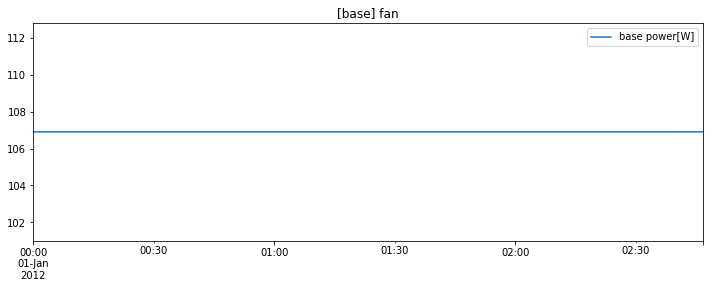

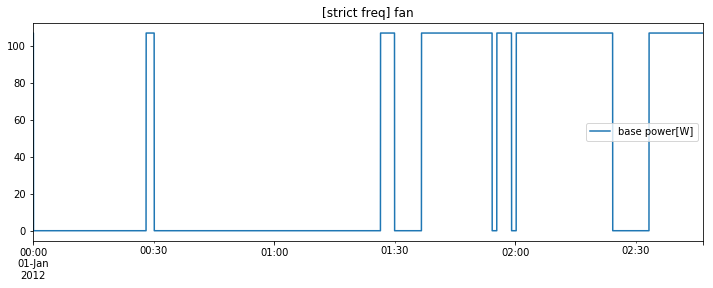

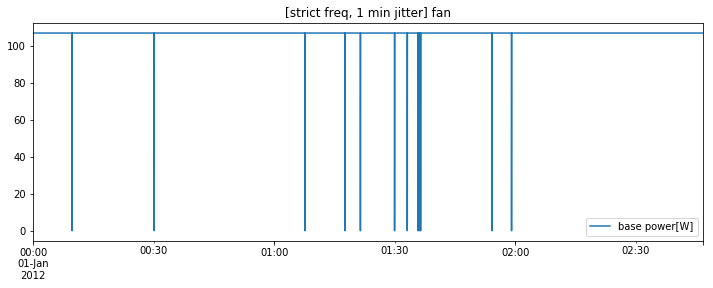

In [32]:
# we look at jitter for the zipload in shorter duration as well
# As we can see, they behave quiet differently since we don't need to consider
# the thermal condition here. Once the frequency violation is detected, we can
# either turn on/turn off the load regardless of the origin schedule
df_base_fan.iloc[:10000].plot(figsize=(12,4),
                             title='[base] fan')
df_strict_fan.iloc[:10000].plot(figsize=(12,4),
                    title='[strict freq] fan')
df_fan_jitter60.iloc[:10000].plot(figsize=(12,4),
        title='[strict freq, 1 min jitter] fan')

 As is seen, after applying the jitter, it tends to correct the power trace from strict frequency control case to the base case. It is obvious for the zipload[fan] case. Let's try the jitter with longer duration to see the same trend for the waterheater.

# Strict Frequency Control with Jitter (10 mins)
We now modify the jitter such that the start of GridBallast event will delay randomly with an expected value of 600 seconds (10 mins) so that we can clearly see the jitter effects in the electric water heater as well.

In [33]:
!head -613 smSingle_strict_freq_jitter600.glm|tail -23

object waterheater {
	schedule_skew -810;
	water_demand weekday_hotwater*1;
	name waterheater1;
	parent house1;
	heating_element_capacity 4.8 kW;
	thermostat_deadband 2.9;
	location INSIDE;
	tank_volume 50;
	tank_setpoint 136.8;
	tank_UA 2.4;
	temperature 135;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.97;
	freq_uplimit 60.03;
	heat_mode ELECTRIC;
	enable_jitter true;
	average_delay_time 600;
};


In [34]:
!head -760 smSingle_strict_freq_jitter600.glm|tail -21

object ZIPload {
	name fan2;
	parent house2;
	power_fraction 0.013500;
	current_fraction 0.253400;
	base_power fan1*0.106899;
	impedance_pf 0.970000;
	current_pf 0.950000;
	power_pf -1.000000;
	impedance_fraction 0.733200;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.97;
	freq_uplimit 60.03;
	enable_jitter true;
	average_delay_time 600;
	groupid fan;
};


In [35]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_strict_freq_jitter600.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 37 objects
Parallelism                    1 thread
Total time                  27.0 seconds
  Core time                  3.5 seconds (13.0%)
    Compiler                 1.3 seconds (4.9%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.1 seconds (0.2%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.2 seconds (0.7%)
  Model time                23.5 seconds/thread (87.0%)
Simulation time                1 days
Simulation speed              33 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock conten

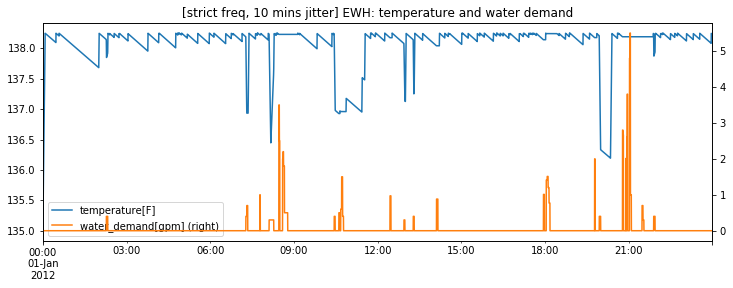

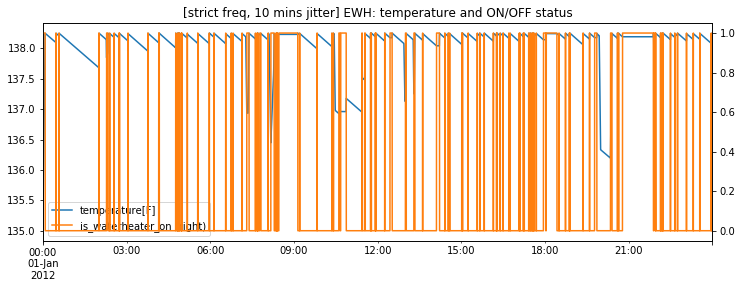

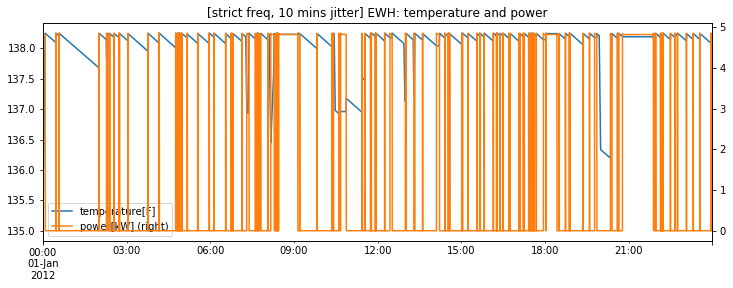

In [36]:
# We save data to wh1_strict_freq_jitter600.csv and plot the results
df_wh_jitter600 = pd.read_csv('wh1_strict_freq_jitter600.csv',sep=',',
                  header=8,index_col=0,parse_dates=True,
                  infer_datetime_format=True,
                  names=['freq[Hz]','temperature[F]','power[kW]',
                        'is_waterheater_on','water_demand[gpm]'])

df_wh_jitter600[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[strict freq, 10 mins jitter] EWH: temperature and water demand')

df_wh_jitter600[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[strict freq, 10 mins jitter] EWH: temperature and ON/OFF status')

df_wh_jitter600[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[strict freq, 10 mins jitter] EWH: temperature and power') 

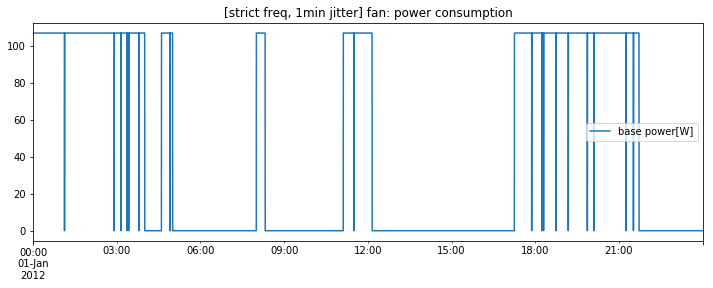

In [37]:
df_fan_jitter600 = pd.read_csv('fan2_strict_freq_jitter600.csv',
                        sep=',',
                        header=8,index_col=0,parse_dates=True,
                        infer_datetime_format=True,
                        names=['base power[W]'])
df_fan_jitter600 = df_fan_jitter600*1000
df_fan_jitter600.plot(figsize=(12,4),
        title='[strict freq, 1min jitter] fan: power consumption')

As we can see, after applying the 10 min jitter, now the water heater is engaged less often than in the previous experiment without jitter.

As we did in previous examples, we now look into a shorter duration to better understand the effect of the jitter.

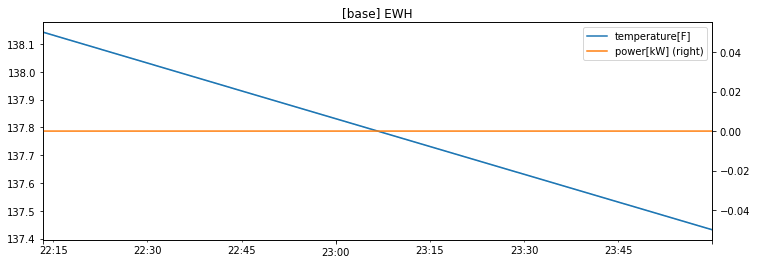

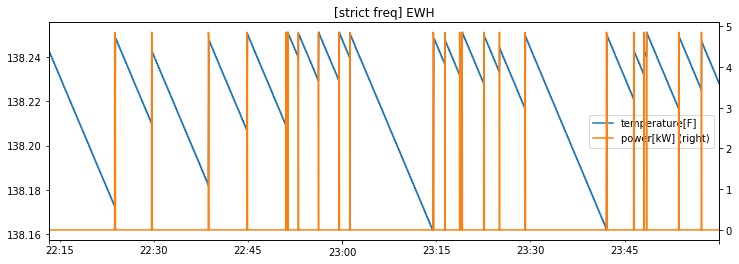

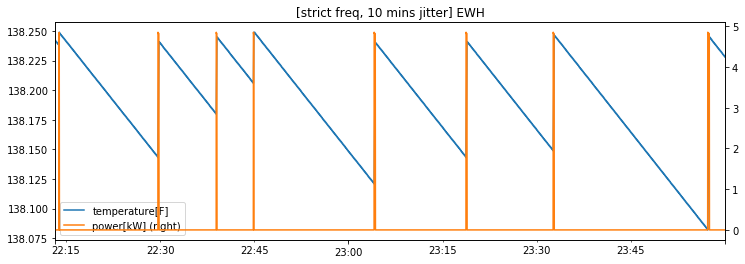

In [38]:
# we look at jitter for the electric water heater in shorter duration
# As we can see, they behave slightly different, the one with jitter behaves
# more like the one without frequency control (base case)
df_base.iloc[80000:100000][['temperature[F]',
        'power[kW]']].plot(figsize=(12,4),
                           secondary_y='power[kW]',
                          title='[base] EWH')
df_strict_freq.iloc[80000:100000][['temperature[F]',
        'power[kW]']].plot(figsize=(12,4),
                           secondary_y='power[kW]',
                          title='[strict freq] EWH')
df_wh_jitter600.iloc[80000:100000][['temperature[F]',
        'power[kW]']].plot(figsize=(12,4),
                           secondary_y='power[kW]',
            title='[strict freq, 10 mins jitter] EWH')

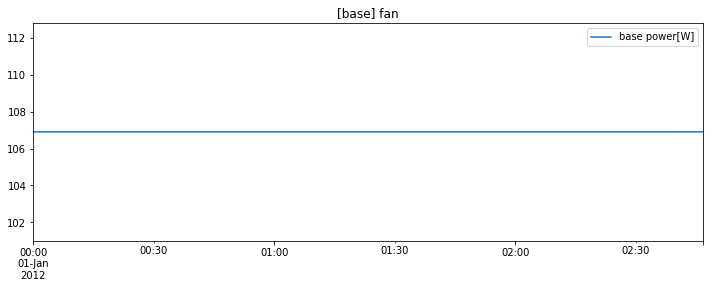

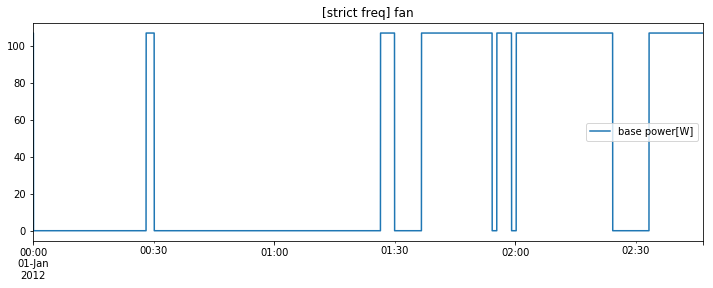

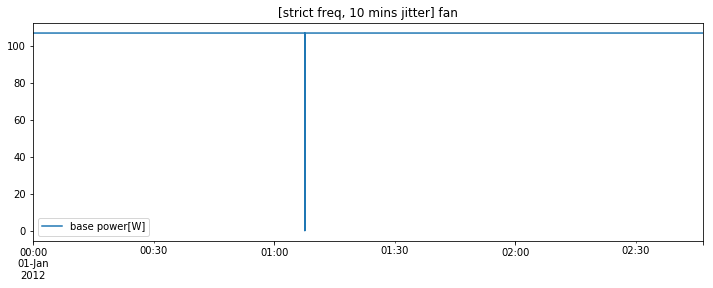

In [39]:
# we look at jitter for the zipload in shorter duration as well
# As we can see, when we apply jitter, it behaves more like 
# the one without frequency control, and the longer the jitter duration, 
# the more likely the power trace becomes to the one with out frequency control
df_base_fan.iloc[:10000].plot(figsize=(12,4),
                             title='[base] fan')
df_strict_fan.iloc[:10000].plot(figsize=(12,4),
                    title='[strict freq] fan')
df_fan_jitter600.iloc[:10000].plot(figsize=(12,4),
        title='[strict freq, 10 mins jitter] fan')